1. What are the primary factors affect the listing price?
2. What are the important features helps owner in becoming super host?
3. Which area in Seattle is most expensive to rent?
4. Is there any seasonal effect in Seattle airbnb listing price? What would be best time to visit if I want to save some money?
5. Are there any homes in 2016 that never occupied? Is there any significant factors in why these places were never rented?

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Initial data lookup
def get_shape(df):
    print('The shape of the dataframe is : '+ str(df.shape))
    
def get_head(df, rows = 5):
    print("########################################################################")
    print(df.head(rows))
    
# Missing Values
def get_missing_values_by_column(df):
    all_cols = df.columns.values
    print(all_cols)
    for col in all_cols:
        missing_percent = df[col].isnull().mean()
        if missing_percent > 0:
            print("Column " + col + " has " + str(float("{0:.2f}".format(missing_percent * 100))) + "% missing values" )
            
def get_float_val (df):
    df.replace(regex=True,inplace=True,to_replace='[^a-zA-Z0-9\n\.]',value='')
    df = df.astype(dtype='float')
    # since host left it blank..replacing null values with 0 
    return df.fillna(value = 0).copy()

def get_bool_val (df):
    df.replace(['t','f'],[1,0],inplace=True)
    df = df.astype(dtype='bool')
    # since host left it blank..replacing null values with 0 
    return df.fillna(value = 0).copy()


def count_days_since(oldDate, currentDate = datetime(2016,1,1,0,0,0)):
    return (currentDate-oldDate).days


def preprocess_features(df):
    '''
    From looking at each of the categorical variable we found that,
    1. experiences_offered, host_verifications, market, has_availability, requires_license columns has only one value hence we need to Drop these columns from dataframe.
    2. 'security_deposit', 'cleaning_fee', 'extra_people' these columns need to be converted to float value of $
    3. amenities need to converted to int where number is total number of amenities
    4. host_response_rate need to converted to float
    5. Transit need to converted to nminal var where NaN = 0 and everuthing else is 1
    6. host_since need to converted to diff between 01/01/2016 - host_since in days

    '''
    #'security_deposit', 'cleaning_fee', 'extra_people',host_acceptance_rate
    df['host_acceptance_rate'] = get_float_val(df['host_acceptance_rate'])
    df['host_response_rate'] = get_float_val(df['host_response_rate'])
    df['security_deposit'] = get_float_val(df['security_deposit'])
    df['cleaning_fee'] = get_float_val(df['cleaning_fee'])
    df['extra_people'] = get_float_val(df['extra_people'])
    df['price'] = get_float_val(df['price'])  # there are no missing values here
    
    
    

    # transit
    df['Transit_available'] = ~ (df.transit.isnull())
    df = df.drop(['transit'],axis=1);

    # Amenities
    df['Facilities'] = df.amenities.apply(lambda a : len(a))
    df = df.drop(['amenities'],axis=1);

    # host since
    df['Host_experience'] = pd.to_datetime(df.host_since).apply(count_days_since)
    df = df.drop(['host_since'],axis=1);
    
    # binary variables
    df['host_is_superhost'] = get_bool_val(df['host_is_superhost'])
    df['require_guest_profile_picture'] = get_bool_val(df['require_guest_profile_picture'])
    df['require_guest_phone_verification'] = get_bool_val(df['require_guest_phone_verification'])
    df['host_has_profile_pic'] = get_bool_val(df['host_has_profile_pic'])
    df['host_identity_verified'] = get_bool_val(df['host_identity_verified'])
    df['is_location_exact'] = get_bool_val(df['is_location_exact'])
    df['has_availability'] = get_bool_val (df['has_availability'])
    df['instant_bookable'] = get_bool_val(df['instant_bookable'])
    

    # Location_Label
    #kmeans = KMeans(n_clusters=5, random_state=0).fit(nlisting_df[['longitude','latitude']])
    #nlisting_df['Location_label'] = kmeans.labels_
    # Show Plot
    #plt.scatter(nlisting_df.longitude.values, nlisting_df.latitude.values, c=nlisting_df['Location_label'].values, alpha=0.5)
    #plt.show()

    #nlisting_df = nlisting_df.drop(['longitude'],axis=1)
    #nlisting_df = nlisting_df.drop(['latitude'],axis=1)

    #experiences_offered, host_verifications, market, has_availability, requires_license
    df = df.drop(['experiences_offered','host_verifications','market','has_availability','requires_license'],axis=1)

    return df


#lets impute data
def impute_features(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    df - pandas dataframe with imputed data
    
    This function cleans df using the following steps to produce X and y:
    1. For each numeric variable in X, fill the column with the mean value of the column.
    2. Lets drop all the rows which has nan values in the 
    '''
   
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    print(num_vars)
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    print(cat_vars)
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    return df

#lets clean the data
def split_data(df,target='price'):
    '''
    INPUT
    df - pandas dataframe 
    target - target var 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no target
    2. Create X as all the columns that are not the target column
    3. Create y as the target column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Drop rows with missing salary values
    df = df.dropna(subset=[target], axis=0)
    y = df[target]
    
    #Drop respondent and expected salary columns
    df = df.drop([target], axis=1)
    
    X = df
    return X, y


def normalise_data(df):   
    # normalise data
    scaler = MinMaxScaler().fit(df)
    return scaler.transform(df)


There are many features that are just informative in nature. To reduce the dimentianllity let us remove such columns from the data.

In [8]:
def data_wrangling(df):

    # Select relavent features for analysis
    selected_vars = ['id', 'experiences_offered',
           'transit', 'host_since', 'host_response_rate',
           'host_acceptance_rate', 'host_is_superhost',
           'host_total_listings_count', 'host_verifications',
           'host_has_profile_pic', 'host_identity_verified', 'market', 
           'zipcode', 'is_location_exact', 'property_type', 'room_type',
           'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
           'amenities', 'square_feet', 'price', 'security_deposit', 'cleaning_fee',
           'guests_included', 'extra_people', 'minimum_nights',
           'maximum_nights', 'has_availability',
           'number_of_reviews',
           'review_scores_rating',
           'review_scores_accuracy', 'review_scores_cleanliness',
           'review_scores_checkin', 'review_scores_communication',
           'review_scores_location', 'review_scores_value',
           'requires_license', 
           'instant_bookable', 'cancellation_policy',
           'require_guest_profile_picture',
           'require_guest_phone_verification',
           'reviews_per_month']

    # remove irrelavant features from dataframe
    df = df[selected_vars]
    print(df.shape)

    # Preprocess the features as per required for analysis
    df = preprocess_features(df)
    print(df.shape)

    # Null Values
    df.columns[df.isnull().mean() > 0]

    #Use the function impute all the Null, nan values
    df = impute_features(df) 
    print(df.shape)

    #Split data
    X,y = split_data(df,'review_scores_rating')
    
    #Normalise Data
    #X = normalise_data(X)
    print(df.shape)
    
    return X,y

In [9]:
# Load csv into dataframes
listing_df= pd.read_csv('..//data//listings.csv')
X,y = data_wrangling(listing_df)
print(X.shape)
print(y)

(3818, 45)


/home/dev/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

(3818, 40)
Index(['id', 'host_response_rate', 'host_acceptance_rate',
       'host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'square_feet', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'Facilities',
       'Host_experience'],
      dtype='object')
Index(['zipcode', 'property_type', 'room_type', 'bed_type',
       'cancellation_policy'],
      dtype='object')
(3818, 85)
(3818, 85)
(3818, 84)
0        95.000000
1        96.000000
2        97.000000
3        94.539262
4        92.000000
5        95.000000
6        99.000000
7        97.000000
8        97.000000
9        97.000000
10       97.000000
11       97.000000
12       

In [10]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#fit the model and obtain pred response
lm_model = LinearRegression(normalize=True)
#lm_model = RandomForestRegressor(max_depth=20, n_estimators=1000,random_state=False, verbose=False)
lm_model.fit(X_train, y_train)
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#append the r2 value from the test set
r2_scores_test= (r2_score(y_test, y_test_preds))
r2_scores_train= (r2_score(y_train, y_train_preds))
results= r2_score(y_test, y_test_preds)

In [11]:
print(results)

0.685070341638198


In [12]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
print(coef_df.head(10))


                      est_int     coefs  abs_coefs
60          zipcode_99\n98122  6.203738   6.203738
68         property_type_Dorm  3.856273   3.856273
53              zipcode_98134 -2.970945   2.970945
56              zipcode_98146  2.954164   2.954164
26        review_scores_value  2.943449   2.943449
78             bed_type_Couch -2.371812   2.371812
22  review_scores_cleanliness  1.951473   1.951473
79             bed_type_Futon -1.951060   1.951060
21     review_scores_accuracy  1.863840   1.863840
66       property_type_Chalet -1.803711   1.803711


# Results

1. Zipcode 
2. Property Type - Dorm
3. review_scores_value
4. Bed Type - couch,futon


In [25]:
def plot_by_target(feature):
    listing_df= pd.read_csv('..//data//listings.csv')
    listing_df['review_scores_rating'] = get_float_val(listing_df['review_scores_rating'])
    listing_df['review_scores_rating'] = listing_df['review_scores_rating'].astype(dtype='float')
    listing_df = listing_df.dropna(subset=['review_scores_rating'],axis=0)
    plotg = listing_df.groupby([feature]).review_scores_rating.mean()
    import matplotlib.pyplot as plt
    _ = plotg.plot(kind='bar',figsize=(10,10),title='Mean Review Rating in USD by ' +feature+ ' in Seattle 2016 airbnb',y= 'Mean Review Rating in $',legend=True)

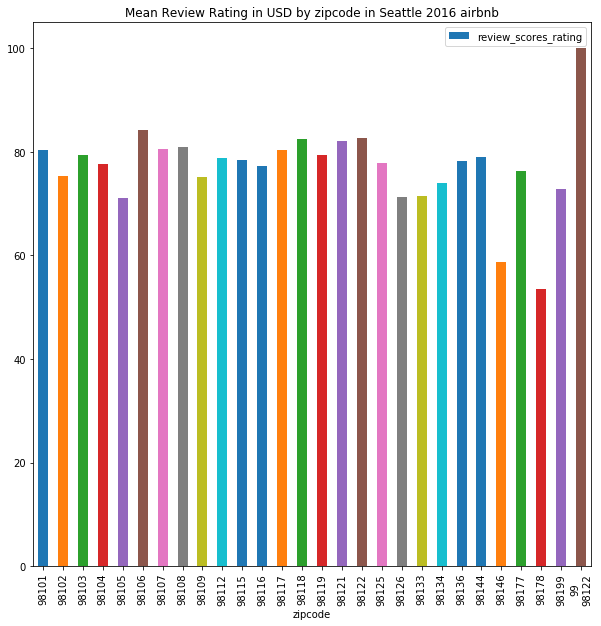

In [26]:
plot_by_target('zipcode')

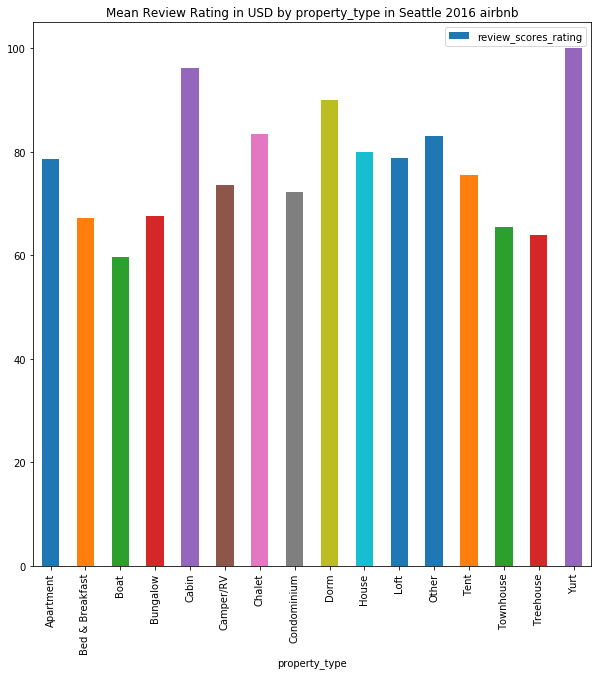

In [27]:
plot_by_target('property_type')

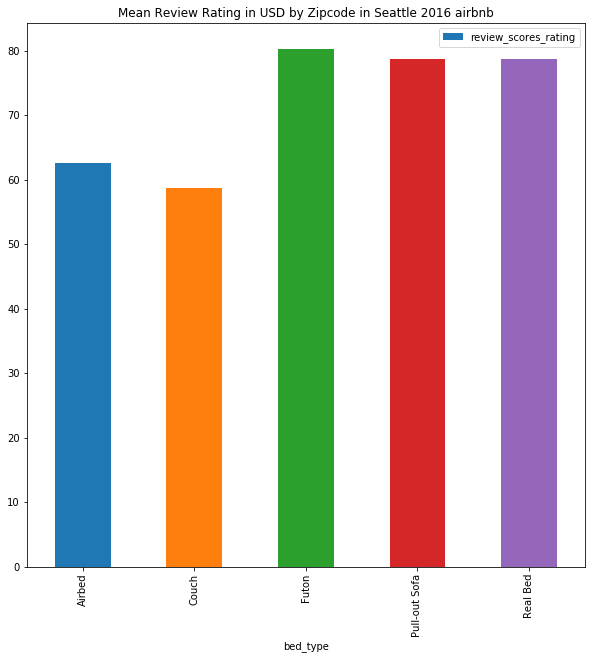

In [22]:
plot_by_target('bed_type')

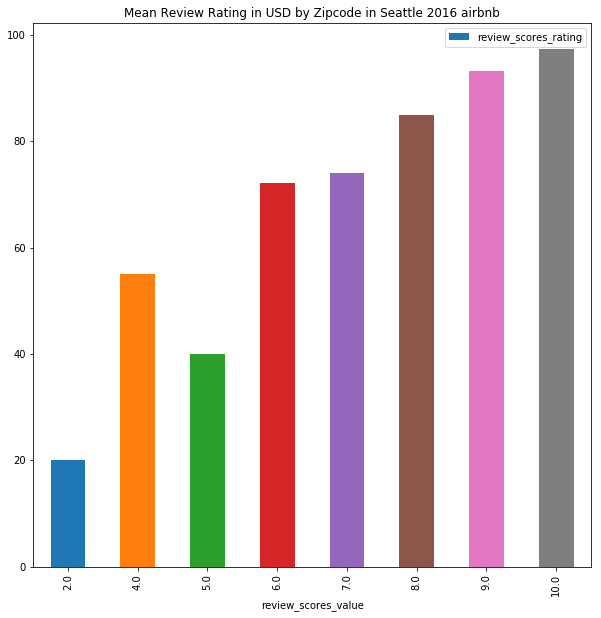

In [23]:
plot_by_target('review_scores_value')